<a href="https://colab.research.google.com/github/alex-durec/DeepSolar_analysis_new_mexico/blob/main/Deep_Solar_Analysis_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepSolar Dataset Analysis       
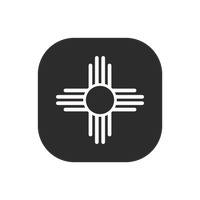
---
### The goal of this analysis to find factors that influence the saturation of solar systems by state. The focus state is New Mexico and the conclusions and recommendations are areas of potential opportunities for Solar Companies in the state of New Mexico.  

---
### Credits:

DeepSolar Project

http://web.stanford.edu/group/deepsolar/home.html

http://web.stanford.edu/group/deepsolar/deepsolar_tract.csv

Sammy Kolpinizki’s Description of Features

https://github.com/sammykol83/UdacityDataScienceNanoDegree/blob/master/Project%20-%20Write%20A%20Data-Science%20Blog/features.txt

Feed-in Tarrif Information:

https://pv-magazine-usa.com/2019/09/27/los-angeles-still-has-a-feed-in-tariff-and-its-growing/

Heating Design Temperature Definition:

https://www.energystar.gov/partner_resources/residential_new/working/hvac/hvac_designers/design_temp_limits

---
#### Contents
*   Import Libraries and Explore Data
*   Data Cleaning and Prep
*   Find Top Correlations
*   Create Dataframes and Function 
  *   Moderate to Strong Correlations
  *   NM, Higher Saturations States, Lower Saturation States
  *   To Create Color Coded Scatter Plots
  *   Confidence Interval Function
*   Explore Top Correlated Factors
  *   Solar Systems Per Capita
  *   Incentives, Rebate, Feed-in Tarriff
      *   Incentive Residential Count
      *   Incentive Nonresidential Count
      *   Incentive Residential State Level
      *   Incentive Nonresidential State Level
      *   Feed-in Tariff
      *   Rebate
  *   Daily Solar Radiation
  *   Electricity Price
      *   Industrial, Commercial, Avg Retail Rate 
      *   Overall
  *   Heating Design Temperature
*   Conclusions and Recommendations

### Import Libraries and Explore Data



In [85]:
import pandas as pd

import seaborn as sns
import scipy
import math
import matplotlib.pyplot as plt

In [86]:
solar_df = pd.read_csv("/content/drive/MyDrive/DeepSolar_Project/deepsolar_tract.csv", encoding='latin-1')
# https://drive.google.com/file/d/1w26ydjqW1PM1xd-qgIZ03HZ6jJWI840F/view?usp=sharing

In [87]:
solar_df.shape

(72537, 169)

In [88]:
solar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72537 entries, 0 to 72536
Columns: 169 entries, Unnamed: 0 to avg_electricity_retail_rate
dtypes: bool(2), float64(117), int64(47), object(3)
memory usage: 92.6+ MB


In [89]:
for column in solar_df.columns:
  print(column, ": ", solar_df[column].dtype)

Unnamed: 0 :  int64
tile_count :  float64
solar_system_count :  float64
total_panel_area :  float64
fips :  int64
average_household_income :  float64
county :  object
education_bachelor :  int64
education_college :  int64
education_doctoral :  int64
education_high_school_graduate :  int64
education_less_than_high_school :  int64
education_master :  int64
education_population :  int64
education_professional_school :  int64
employed :  int64
gini_index :  float64
heating_fuel_coal_coke :  int64
heating_fuel_electricity :  int64
heating_fuel_fuel_oil_kerosene :  int64
heating_fuel_gas :  int64
heating_fuel_housing_unit_count :  int64
heating_fuel_none :  int64
heating_fuel_other :  int64
heating_fuel_solar :  int64
land_area :  float64
per_capita_income :  float64
population :  int64
population_density :  float64
poverty_family_below_poverty_level :  int64
poverty_family_count :  int64
race_asian :  int64
race_black_africa :  int64
race_indian_alaska :  int64
race_islander :  int64
race_o

Exploring 'number_of_solar_system_per_household' to asses if it is an appropriate measure for solar system saturation. 

There are many INF and NaN values so a new factor will be created.

In [90]:
num_solar_hh = solar_df['number_of_solar_system_per_household']
num_solar_hh.sort_values(ascending=False)

34414    inf
52638    inf
34005    inf
16629    inf
461      inf
        ... 
71805    NaN
71832    NaN
71974    NaN
72416    NaN
72425    NaN
Name: number_of_solar_system_per_household, Length: 72537, dtype: float64

### Data Cleaning and Prep



Creating new field 'solar_system_per_capita' which is the sum of each state's 'solar_system_count' / sum of each state's 'population'



In [91]:
solar_per_cap = solar_df[["solar_system_count", "state", "population"]]
solar_per_cap_grouped = solar_per_cap.groupby(['state']).sum()
solar_per_cap_grouped = solar_per_cap_grouped.assign(solar_system_per_capita = (solar_per_cap_grouped.solar_system_count / solar_per_cap_grouped.population))
solar_per_cap_join = solar_per_cap_grouped.drop(['solar_system_count', 'population'], axis=1)
solar_df_per_cap = solar_df.merge(solar_per_cap_join, left_on='state', right_index=True)

### Find Top Correlations

In [92]:
solar_sat_corr_df = solar_df_per_cap.corr()
solar_sat_corr_df.sort_values(by='solar_system_per_capita', ascending=False, inplace=True)
print('Top 20 Correlations with Solar System per Capita')
solar_sat_corr_df['solar_system_per_capita'].head(20)

Top 20 Correlations with Solar System per Capita


solar_system_per_capita                 1.000000
incentive_count_residential             0.811684
incentive_count_nonresidential          0.793869
daily_solar_radiation                   0.735794
electricity_price_industrial            0.712573
feedin_tariff                           0.712464
electricity_price_commercial            0.630161
rebate                                  0.624075
electricity_price_overall               0.607066
solar_panel_area_divided_by_area        0.596951
avg_electricity_retail_rate             0.581674
incentive_residential_state_level       0.578427
incentive_nonresidential_state_level    0.537043
heating_design_temperature              0.510073
solar_system_count                      0.497833
solar_system_count_residential          0.496559
tile_count_residential                  0.491867
total_panel_area_residential            0.477690
earth_temperature                       0.474125
electricity_price_residential           0.464109
Name: solar_system_p

Heatmap for Correlations with 'solar_system_per_capita' over 0.5

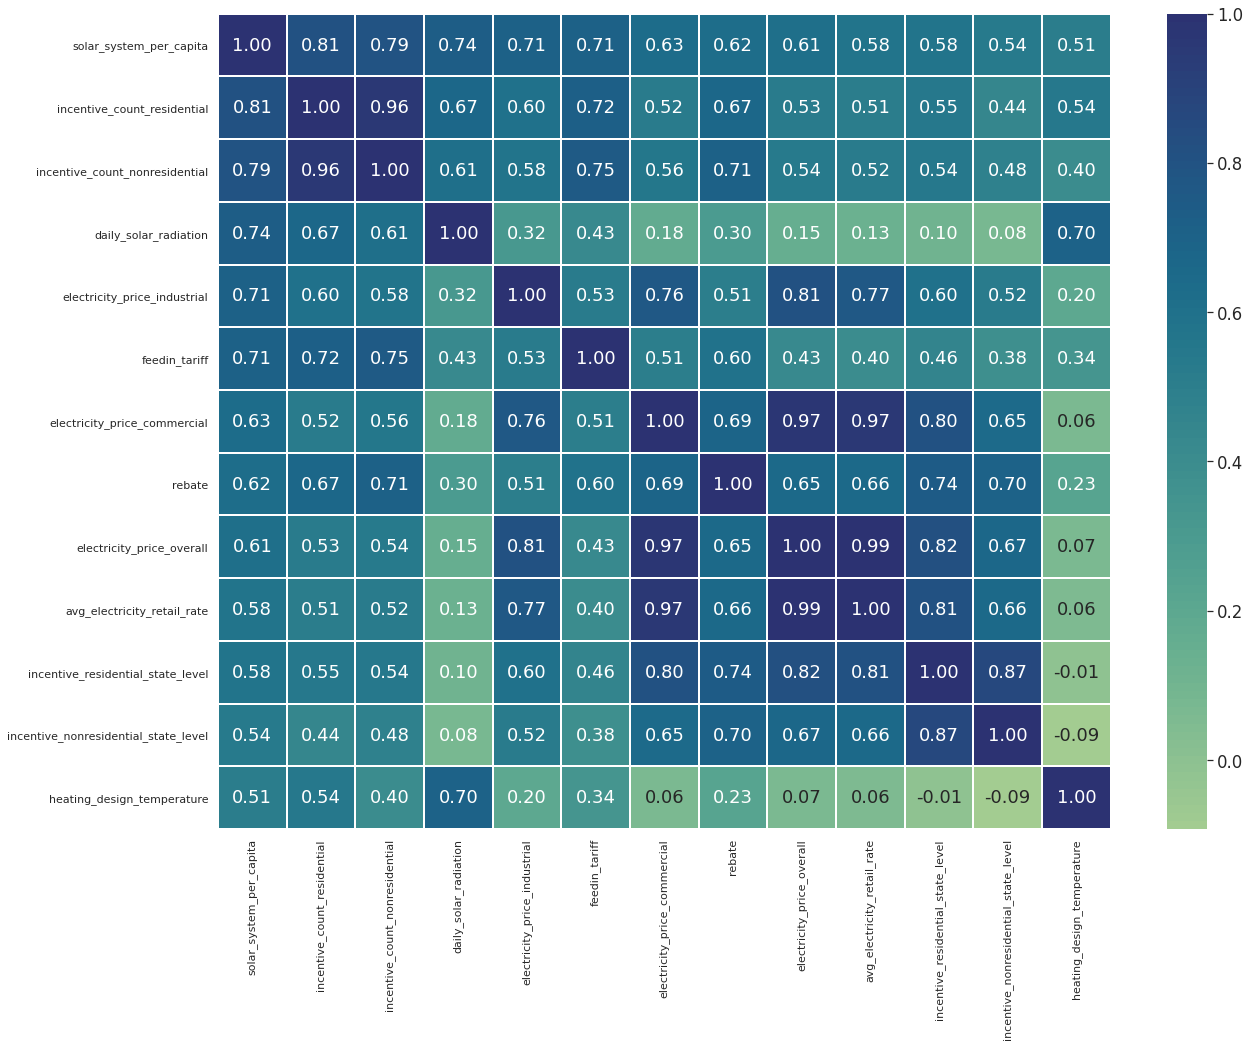

In [93]:
corr_solar_saturation = ['solar_system_per_capita', 'incentive_count_residential', 'incentive_count_nonresidential', 'daily_solar_radiation', 'electricity_price_industrial', 'feedin_tariff', 'electricity_price_commercial', 'rebate', 'electricity_price_overall', 'avg_electricity_retail_rate', 'incentive_residential_state_level', 'incentive_nonresidential_state_level', 'heating_design_temperature']

fig, axe = plt.subplots(figsize=(20,15))
sns.set_context("poster")

sns.set(font_scale=1.5)
corrmap = sns.color_palette("crest", 100)

sns.heatmap(solar_df_per_cap[corr_solar_saturation].corr(),annot=True, fmt='.2f',linewidths=1,cmap = corrmap)

### Create Dataframes and Function

#### Moderate to Strong Correlations

In [94]:
high_corr_solar_df = solar_df_per_cap[["state", 'solar_system_per_capita', 'incentive_count_residential', 'incentive_count_nonresidential', 'daily_solar_radiation', 'electricity_price_industrial', 'feedin_tariff', 'electricity_price_commercial', 'rebate', 'electricity_price_overall', 'avg_electricity_retail_rate', 'incentive_residential_state_level', 'incentive_nonresidential_state_level', 'heating_design_temperature']]

#### NM, Higher Saturations States, Lower Saturation States

In [95]:
solar_sat_df = solar_df_per_cap[["solar_system_per_capita", "state"]]
solar_sat_df_grouped = solar_sat_df.groupby(['state']).mean()
solar_sat_df_grouped.sort_values(by='solar_system_per_capita', ascending=False)

,solar_system_per_capita
state,
ca,0.018044
az,0.015355
nv,0.014371
fl,0.007909
ma,0.007459
nj,0.006708
nm,0.006436
co,0.006398
ct,0.005049


In [96]:
# NM Saturation
# Nulls filled with Mean
nm_solar_df_na = high_corr_solar_df.loc[high_corr_solar_df['state'] == 'nm']
nm_solar_df = nm_solar_df_na.fillna(nm_solar_df_na.mean())

# States with Saturation Higher Than NM 
# Nulls filled with Mean
higher_states = high_corr_solar_df.state[(high_corr_solar_df['solar_system_per_capita'] > 0.006436)]
high_filter = high_corr_solar_df['state'].isin(higher_states)
higher_sat_solar_df_na = high_corr_solar_df[high_filter]
higher_sat_solar_df = higher_sat_solar_df_na.fillna(higher_sat_solar_df_na.mean())

# States with Saturation Lower Than NM 
# Nulls filled with Mean
lower_states = high_corr_solar_df.state[(high_corr_solar_df['solar_system_per_capita'] < 0.006436)]
low_filter = high_corr_solar_df['state'].isin(lower_states)
lower_sat_solar_df_na = high_corr_solar_df[low_filter]
lower_sat_solar_df = lower_sat_solar_df_na.fillna(lower_sat_solar_df_na.mean())

#### To Create Color Coded Scatter Plots

In [97]:
nm_solar_df_color = nm_solar_df.assign(high_low_nm = 'nm')
higher_sat_solar_df_color = higher_sat_solar_df.assign(high_low_nm = 'higher')
lower_sat_solar_df_color = lower_sat_solar_df.assign(high_low_nm = 'lower')
state_means_df_merged_one = nm_solar_df_color.append(higher_sat_solar_df_color)
state_means_df_merged = state_means_df_merged_one.append(lower_sat_solar_df_color)
state_means_df = state_means_df_merged.groupby(['state', 'high_low_nm']).mean()

#### Confidence Interval Function

In [98]:
def get_95_ci(array_1, array_2):
    sample_1_n = array_1.shape[0]
    sample_2_n = array_2.shape[0]
    sample_1_mean = array_1.mean()
    sample_2_mean = array_2.mean()
    sample_1_var = array_1.var()
    sample_2_var = array_2.var()
    mean_difference = sample_2_mean - sample_1_mean
    std_err_difference = math.sqrt((sample_1_var/sample_1_n)+(sample_2_var/sample_2_n))
    margin_of_error = 1.96 * std_err_difference
    ci_lower = mean_difference - margin_of_error
    ci_upper = mean_difference + margin_of_error
    return("The difference in means at the 95% confidence interval (two-tail) is between "+str(ci_lower)+" and "+str(ci_upper)+".")

### Explore Top Correlated Factors and Solar System Saturation

#### Solar Systems Per Capita

Scatter Plot Preview

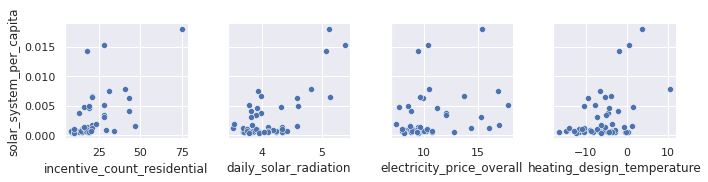

In [99]:
sns.set(font_scale=1)
sns.pairplot(state_means_df, y_vars='solar_system_per_capita', x_vars=['incentive_count_residential', 'daily_solar_radiation', 'electricity_price_overall', 'heating_design_temperature'])

Distribution Visualizations with Box Plot and Histogram


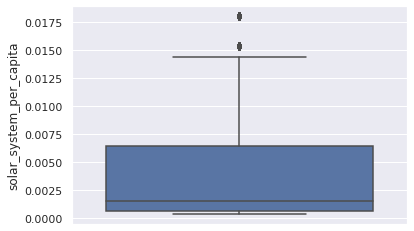

In [100]:
sns.boxplot(y="solar_system_per_capita", data=high_corr_solar_df)

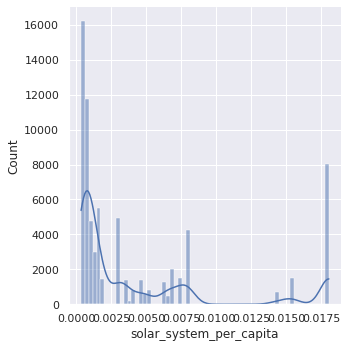

In [101]:
ax = sns.displot(high_corr_solar_df['solar_system_per_capita'], kde=True)

Statistical Analysis



In [102]:
print('Higher vs NM: ', scipy.stats.ttest_ind(higher_sat_solar_df['solar_system_per_capita'], nm_solar_df['solar_system_per_capita']))
print('Lower vs. NM: ', scipy.stats.ttest_ind(lower_sat_solar_df['solar_system_per_capita'], nm_solar_df['solar_system_per_capita']))

Higher vs NM:  Ttest_indResult(statistic=28.921290136332935, pvalue=5.052255883288554e-180)
Lower vs. NM:  Ttest_indResult(statistic=-76.97808032655175, pvalue=0.0)


Reject the null hypothesis that there is no difference between the population means of Higher Saturation States and New Mexico Solar Saturation (p << 0.05)

Reject the null hypothesis that there is no difference between the population means of Lower Saturation States and New Mexico Solar Saturation (p < 0.05)


In [103]:
print('Higher vs. NM: ', get_95_ci(higher_sat_solar_df['solar_system_per_capita'], nm_solar_df['solar_system_per_capita']))
print('Lower vs. NM: ', get_95_ci(lower_sat_solar_df['solar_system_per_capita'], nm_solar_df['solar_system_per_capita']))

Higher vs. NM:  The difference in means at the 95% confidence interval (two-tail) is between -0.00660662652268023 and -0.006461186852026353.
Lower vs. NM:  The difference in means at the 95% confidence interval (two-tail) is between 0.004901342357968745 and 0.004925386134502343.


###### Solar Systems Per Capita Conclusions:


As can be seen by the distribution visualizations most states have low saturation with a few outliers.

As would be expected New Mexico is only slightly less saturated than states with higher saturation and slightly more saturated than states with lower saturation.

#### All Incentives: Incentives, Rebate, Feed-in Tarriff

##### Incentive Residential Count

Distribution Visualizations with Box Plot and Histogram



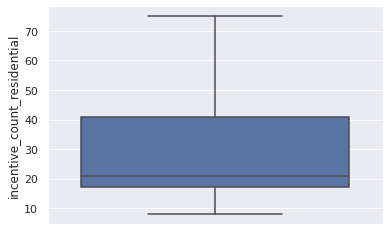

In [104]:
sns.boxplot(y='incentive_count_residential', data=high_corr_solar_df)

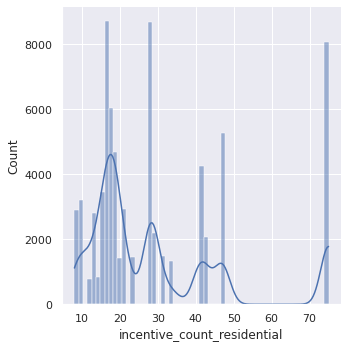

In [105]:
ax = sns.displot(high_corr_solar_df['incentive_count_residential'], kde=True)

Correlation Visualized with Scatter Plot

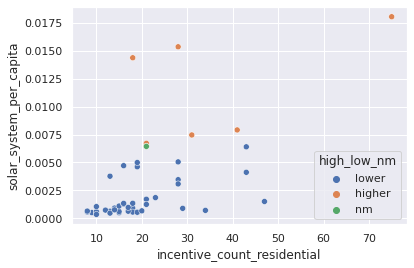

In [106]:
sns.scatterplot(x='incentive_count_residential', y="solar_system_per_capita", hue='high_low_nm', data=state_means_df)

Statistical Analysis

In [107]:
print('Higher vs. NM: ', scipy.stats.ttest_ind(higher_sat_solar_df['incentive_count_residential'], nm_solar_df['incentive_count_residential']))
print('Lower vs. NM: ', scipy.stats.ttest_ind(lower_sat_solar_df['incentive_count_residential'], nm_solar_df['incentive_count_residential']))

Higher vs. NM:  Ttest_indResult(statistic=29.006607375377232, pvalue=4.72556290096921e-181)
Lower vs. NM:  Ttest_indResult(statistic=2.9303146335650174, pvalue=0.0033875932059181883)


Reject the null hypothesis that there is no difference between the population means of Higher Saturation States and New Mexico Incentive Residential Count (p << 0.05)

Reject the null hypothesis that there is no difference between the population means of Lower Saturation States and New Mexico Incentive Residential Count (p < 0.05)

In [108]:
print('Higher vs. NM: ', get_95_ci(higher_sat_solar_df['incentive_count_residential'], nm_solar_df['incentive_count_residential']))
print('Lower vs. NM: ', get_95_ci(lower_sat_solar_df['incentive_count_residential'], nm_solar_df['incentive_count_residential']))

Higher vs. NM:  The difference in means at the 95% confidence interval (two-tail) is between -29.69321709527965 and -29.041445895910016.
Lower vs. NM:  The difference in means at the 95% confidence interval (two-tail) is between -1.5503452998299747 and -1.3630827851504068.


##### Incentive Nonresidential Count

Distribution Visualizations with Box Plot and Histogram

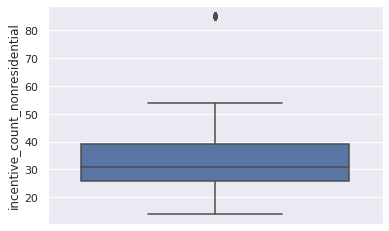

In [109]:
sns.boxplot(y='incentive_count_nonresidential', data=high_corr_solar_df)

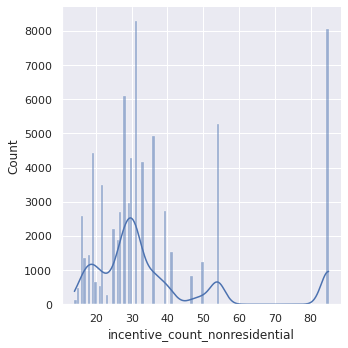

In [110]:
ax = sns.displot(high_corr_solar_df['incentive_count_nonresidential'], kde=True)

Correlation Visualized with Scatter Plot

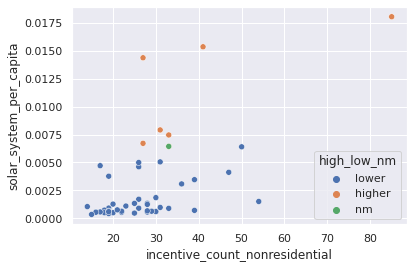

In [111]:
sns.scatterplot(x='incentive_count_nonresidential', y="solar_system_per_capita", hue='high_low_nm', data=state_means_df)

Statistical Analysis

In [112]:
print('Higher vs. NM: ', scipy.stats.ttest_ind(higher_sat_solar_df['incentive_count_nonresidential'], nm_solar_df['incentive_count_nonresidential']))
print('Lower vs. NM: ', scipy.stats.ttest_ind(lower_sat_solar_df['incentive_count_nonresidential'], nm_solar_df['incentive_count_nonresidential']))

Higher vs. NM:  Ttest_indResult(statistic=18.465662875442952, pvalue=1.7855596986837755e-75)
Lower vs. NM:  Ttest_indResult(statistic=-5.210632869700018, pvalue=1.8888073971825455e-07)


Reject the null hypothesis that there is no difference between the population means of Higher Saturation States and New Mexico Incentive Nonresidential Count (p << 0.05)

Reject the null hypothesis that there is no difference between the population means of Lower Saturation States and New Mexico Incentive Nonresidential Count (p << 0.05)

In [113]:
print('Higher vs. NM: ', get_95_ci(higher_sat_solar_df['incentive_count_nonresidential'], nm_solar_df['incentive_count_nonresidential']))
print('Lower vs. NM: ', get_95_ci(lower_sat_solar_df['incentive_count_nonresidential'], nm_solar_df['incentive_count_nonresidential']))

Higher vs. NM:  The difference in means at the 95% confidence interval (two-tail) is between -22.351925031448246 and -21.586024268589583.
Lower vs. NM:  The difference in means at the 95% confidence interval (two-tail) is between 2.420317409295151 and 2.6018529956200926.


##### Incentive Residential State Level

Distribution Visualizations with Box Plot and Histogram

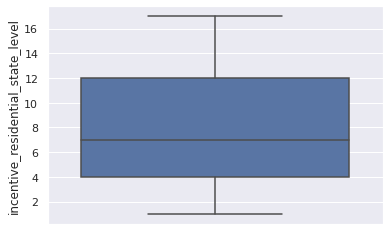

In [114]:
sns.boxplot(y='incentive_residential_state_level', data=high_corr_solar_df)

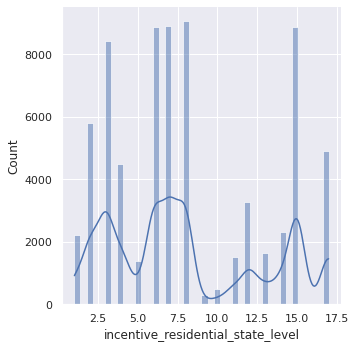

In [115]:
ax = sns.displot(high_corr_solar_df['incentive_residential_state_level'], kde=True)

Correlation Visualized with Scatter Plot

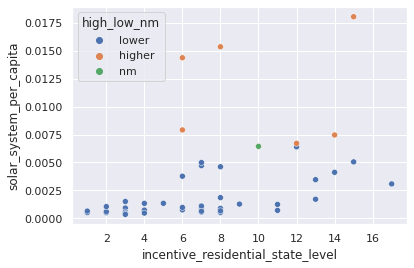

In [116]:
sns.scatterplot(x='incentive_residential_state_level', y="solar_system_per_capita", hue='high_low_nm', data=state_means_df)

Statistical Analysis

In [117]:
print('Higher vs. NM: ', scipy.stats.ttest_ind(higher_sat_solar_df['incentive_residential_state_level'], nm_solar_df['incentive_residential_state_level']))
print('Lower vs. NM: ', scipy.stats.ttest_ind(lower_sat_solar_df['incentive_residential_state_level'], nm_solar_df['incentive_residential_state_level']))

Higher vs. NM:  Ttest_indResult(statistic=8.552848573833975, pvalue=1.2907141397510512e-17)
Lower vs. NM:  Ttest_indResult(statistic=-15.110124345525646, pvalue=1.766175334874145e-51)


Reject the null hypothesis that there is no difference between the population means of Higher Saturation States and New Mexico Incentive Residential State Level (p << 0.05)

Reject the null hypothesis that there is no difference between the population means of Lower Saturation States and New Mexico Incentive Residential State Level (p << 0.05)

In [118]:
print('Higher vs. NM: ', get_95_ci(higher_sat_solar_df['incentive_residential_state_level'], nm_solar_df['incentive_residential_state_level']))
print('Lower vs. NM: ', get_95_ci(lower_sat_solar_df['incentive_residential_state_level'], nm_solar_df['incentive_residential_state_level']))

Higher vs. NM:  The difference in means at the 95% confidence interval (two-tail) is between -1.53853257870487 and -1.4269287477099197.
Lower vs. NM:  The difference in means at the 95% confidence interval (two-tail) is between 3.0403854919190514 and 3.1171391213017636.


##### Incentive Nonresidential State Level

Distribution Visualizations with Box Plot and Histogram

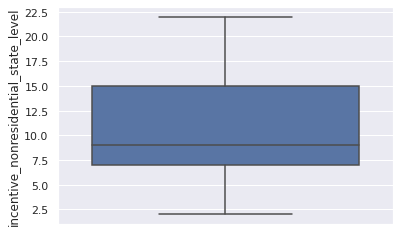

In [119]:
sns.boxplot(y='incentive_nonresidential_state_level', data=high_corr_solar_df)

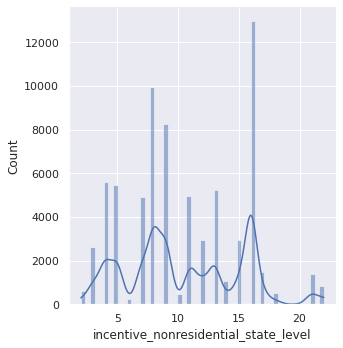

In [120]:
ax = sns.displot(high_corr_solar_df['incentive_nonresidential_state_level'], kde=True)

Correlation Visualized with Scatter Plot

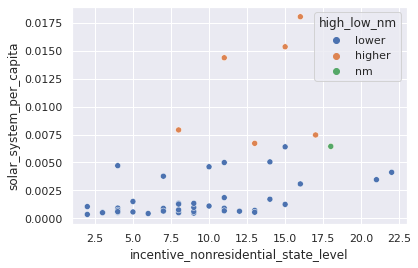

In [121]:
sns.scatterplot(x='incentive_nonresidential_state_level', y="solar_system_per_capita", hue='high_low_nm', data=state_means_df)

Statistical Analysis

In [122]:
print('Higher vs NM: ', scipy.stats.ttest_ind(higher_sat_solar_df['incentive_nonresidential_state_level'], nm_solar_df['incentive_nonresidential_state_level']))
print('Lower vs. NM: ', scipy.stats.ttest_ind(lower_sat_solar_df['incentive_nonresidential_state_level'], nm_solar_df['incentive_nonresidential_state_level']))

Higher vs NM:  Ttest_indResult(statistic=-28.185681402348333, pvalue=2.8891656227784816e-171)
Lower vs. NM:  Ttest_indResult(statistic=-42.068289387318856, pvalue=0.0)


Reject the null hypothesis that there is no difference between the population means of Higher Saturation States and New Mexico Incentive Nonresidential State Level(p << 0.05)

Reject the null hypothesis that there is no difference between the population means of Lower Saturation States and New Mexico Incentive Nonresidential State Level (p < 0.05)

In [123]:
print('Higher vs. NM: ', get_95_ci(higher_sat_solar_df['incentive_nonresidential_state_level'], nm_solar_df['incentive_nonresidential_state_level']))
print('Lower vs. NM: ', get_95_ci(lower_sat_solar_df['incentive_nonresidential_state_level'], nm_solar_df['incentive_nonresidential_state_level']))

Higher vs. NM:  The difference in means at the 95% confidence interval (two-tail) is between 4.246763225493128 and 4.344880469442282.
Lower vs. NM:  The difference in means at the 95% confidence interval (two-tail) is between 8.574860408516418 and 8.651988358971924.


##### Feed-in Tariff

Distribution Visualizations with Box Plot and Histogram

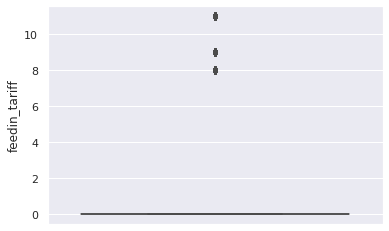

In [124]:
sns.boxplot(y='feedin_tariff', data=high_corr_solar_df)

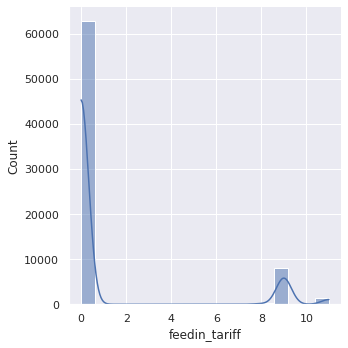

In [125]:
ax = sns.displot(high_corr_solar_df['feedin_tariff'], kde=True)

Correlation Visualized with Scatter Plot

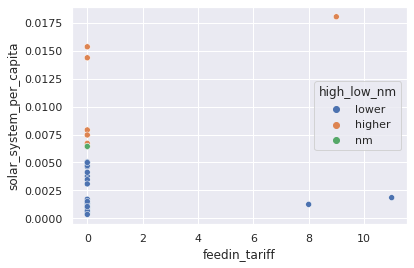

In [126]:
sns.scatterplot(x='feedin_tariff', y="solar_system_per_capita", hue='high_low_nm', data=state_means_df)

Statistical Analysis

In [127]:
print('Higher vs NM: ', scipy.stats.ttest_ind(higher_sat_solar_df['feedin_tariff'], nm_solar_df['feedin_tariff']))
print('Lower vs. NM: ', scipy.stats.ttest_ind(lower_sat_solar_df['feedin_tariff'], nm_solar_df['feedin_tariff']))

Higher vs NM:  Ttest_indResult(statistic=19.617014839935603, pvalue=7.646147978636352e-85)
Lower vs. NM:  Ttest_indResult(statistic=3.9385070299555234, pvalue=8.209209477179292e-05)


Reject the null hypothesis that there is no difference between the population means of Higher Saturation States and New Mexico Feed-in Tariff(p << 0.05)

Reject the null hypothesis that there is no difference between the population means of Lower Saturation States and New Mexico Feed-in Tariff (p << 0.05)

In [128]:
print('Higher vs. NM: ', get_95_ci(higher_sat_solar_df['feedin_tariff'], nm_solar_df['feedin_tariff']))
print('Lower vs. NM: ', get_95_ci(lower_sat_solar_df['feedin_tariff'], nm_solar_df['feedin_tariff']))

Higher vs. NM:  The difference in means at the 95% confidence interval (two-tail) is between -3.983226335402156 and -3.854620267484174.
Lower vs. NM:  The difference in means at the 95% confidence interval (two-tail) is between -0.33953967727323014 and -0.30854678360470306.


##### Rebate

Distribution Visualizations with Box Plot and Histogram

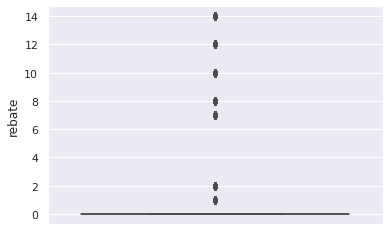

In [129]:
sns.boxplot(y='rebate', data=high_corr_solar_df)

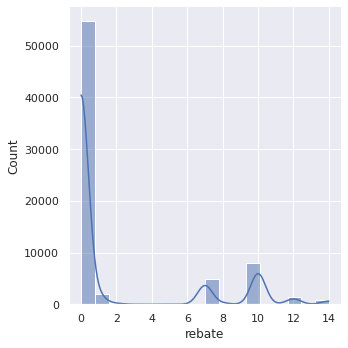

In [130]:
ax = sns.displot(high_corr_solar_df['rebate'], kde=True)

Correlation Visualized with Scatter Plot

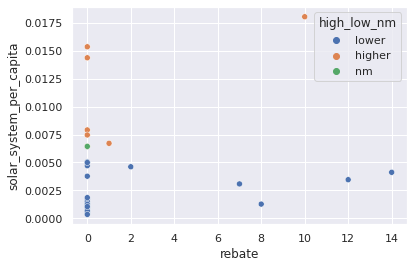

In [131]:
sns.scatterplot(x='rebate', y="solar_system_per_capita", hue='high_low_nm', data=state_means_df)

Statistical Analysis

In [132]:
print('Higher vs NM: ', scipy.stats.ttest_ind(higher_sat_solar_df['rebate'], nm_solar_df['rebate']))
print('Lower vs. NM: ', scipy.stats.ttest_ind(lower_sat_solar_df['rebate'], nm_solar_df['rebate']))

Higher vs NM:  Ttest_indResult(statistic=20.463052365780896, pvalue=4.516205502913057e-92)
Lower vs. NM:  Ttest_indResult(statistic=8.548497526305736, pvalue=1.2787396803749765e-17)


Reject the null hypothesis that there is no difference between the population means of Higher Saturation States and New Mexico Rebate (p << 0.05)

Reject the null hypothesis that there is no difference between the population means of Lower Saturation States and New Mexico Rebate (p << 0.05)

In [133]:
print('Higher vs. NM: ', get_95_ci(higher_sat_solar_df['rebate'], nm_solar_df['rebate']))
print('Lower vs. NM: ', get_95_ci(lower_sat_solar_df['rebate'], nm_solar_df['rebate']))

Higher vs. NM:  The difference in means at the 95% confidence interval (two-tail) is between -4.533204776114837 and -4.392799223668958.
Lower vs. NM:  The difference in means at the 95% confidence interval (two-tail) is between -1.2439688663162118 and -1.1903341909049.


##### Incentives, Rebate, Feed-in Tarriff Conclusion:

As can be seen by the distribution visualizations most states have low incentives with a few outliers. The exceptions are Incentive Residential State Level and Incentive Nonresidential State Level which have a more even distribution.

In general New Mexico has less incentives than the states with higher solar system saturation.

#### Daily Solar Radiation

Distribution Visualizations with Box Plot and Histogram

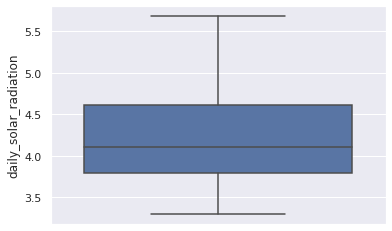

In [134]:
sns.boxplot(y='daily_solar_radiation', data=high_corr_solar_df)

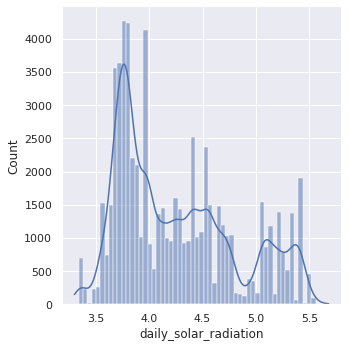

In [135]:
ax = sns.displot(high_corr_solar_df['daily_solar_radiation'], kde=True)

Correlation Visualized with Scatter Plot

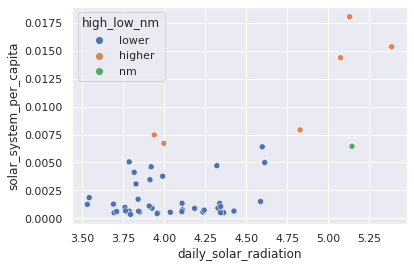

In [136]:
sns.scatterplot(x='daily_solar_radiation', y="solar_system_per_capita", hue='high_low_nm', data=state_means_df)

Statistical Analysis

In [137]:
print('Higher vs NM: ', scipy.stats.ttest_ind(higher_sat_solar_df['daily_solar_radiation'], nm_solar_df['daily_solar_radiation']))
print('Lower vs. NM: ', scipy.stats.ttest_ind(lower_sat_solar_df['daily_solar_radiation'], nm_solar_df['daily_solar_radiation']))

Higher vs NM:  Ttest_indResult(statistic=-11.853797046847802, pvalue=2.673125736425455e-32)
Lower vs. NM:  Ttest_indResult(statistic=-72.17844770705952, pvalue=0.0)


Reject the null hypothesis that there is no difference between the population means of Higher Saturation States and New Mexico Daily Solar Radiation (p << 0.05)

Reject the null hypothesis that there is no difference between the population means of Lower Saturation States and New Mexico Daily Solar Radiation (p < 0.05)

In [138]:
print('Higher vs. NM: ', get_95_ci(higher_sat_solar_df['daily_solar_radiation'], nm_solar_df['feedin_tariff']))
print('Lower vs. NM: ', get_95_ci(lower_sat_solar_df['daily_solar_radiation'], nm_solar_df['daily_solar_radiation']))

Higher vs. NM:  The difference in means at the 95% confidence interval (two-tail) is between -4.869727391108911 and -4.854377955336651.
Lower vs. NM:  The difference in means at the 95% confidence interval (two-tail) is between 1.1007696060116097 and 1.1186320594151133.


##### Daily Solar Radiation Conclusion:

As can be seen by the distribution visualizations most states have fairly low Daily Solar Radiation.

New Mexico has lower Daily Solar Radiation than states with higher solar system saturation and slightly higher  than states with lower solar system saturation.

#### Electricity Price

##### Industrial, Commercial, Average Retail Rate

Because these factors are so closely related in-depth analysis will only be shown for Overall Electricity Price. 

Visualizations are provided below for reference.

Visualize Distribution with Box Plots

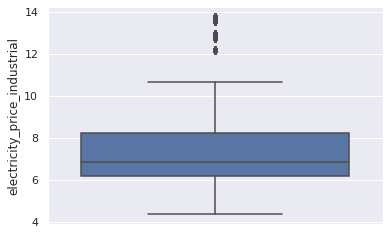

In [139]:
sns.boxplot(y='electricity_price_industrial', data=high_corr_solar_df)

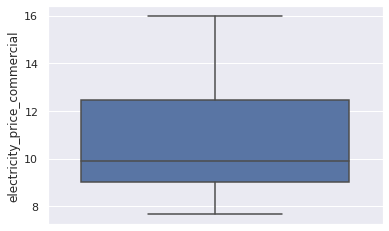

In [140]:
sns.boxplot(y='electricity_price_commercial', data=high_corr_solar_df)

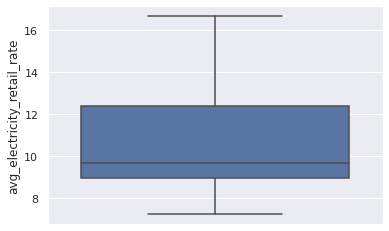

In [141]:
sns.boxplot(y='avg_electricity_retail_rate', data=high_corr_solar_df)

Visualize Distribution with Histograms

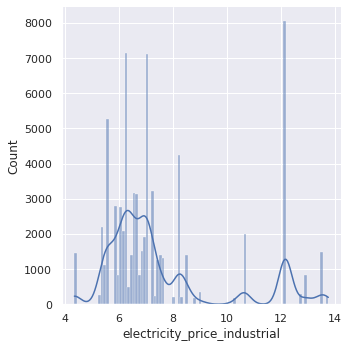

In [142]:
ax = sns.displot(high_corr_solar_df['electricity_price_industrial'], kde=True)

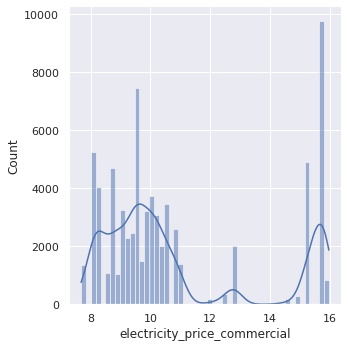

In [143]:
ax = sns.displot(high_corr_solar_df['electricity_price_commercial'], kde=True)

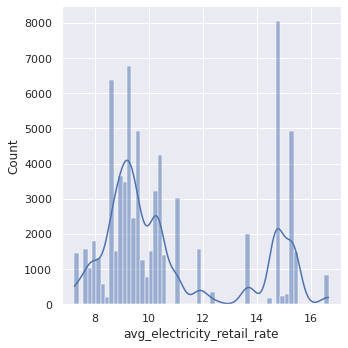

In [144]:
ax = sns.displot(high_corr_solar_df['avg_electricity_retail_rate'], kde=True)

Visualize Correlation with Scatter Plots

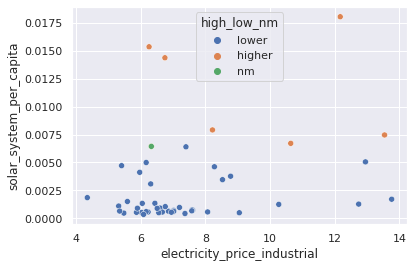

In [145]:
sns.scatterplot(x='electricity_price_industrial', y="solar_system_per_capita", hue='high_low_nm', data=state_means_df)

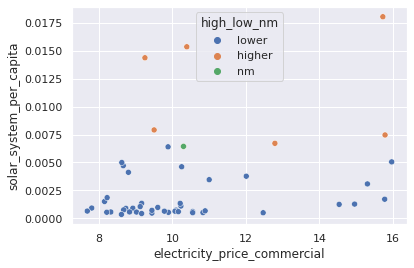

In [146]:
sns.scatterplot(x='electricity_price_commercial', y="solar_system_per_capita", hue='high_low_nm', data=state_means_df)

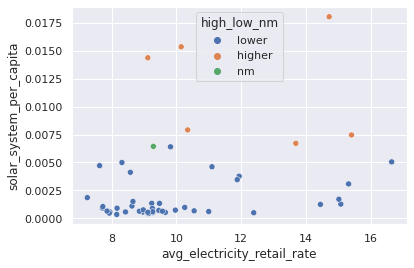

In [147]:
sns.scatterplot(x='avg_electricity_retail_rate', y="solar_system_per_capita", hue='high_low_nm', data=state_means_df)

##### Overall

Distribution Visualizations with Box Plot and Histogram

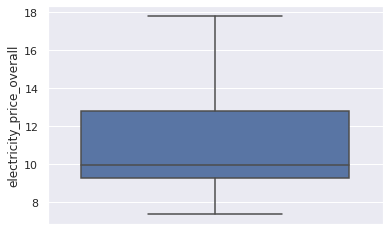

In [148]:
sns.boxplot(y='electricity_price_overall', data=high_corr_solar_df)

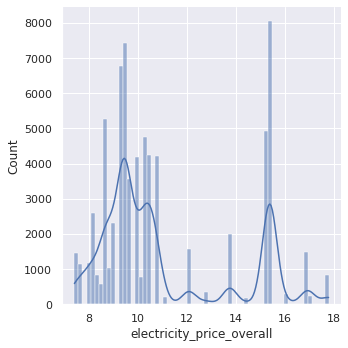

In [149]:
ax = sns.displot(high_corr_solar_df['electricity_price_overall'], kde=True)

Correlation Visualized with Scatter Plot

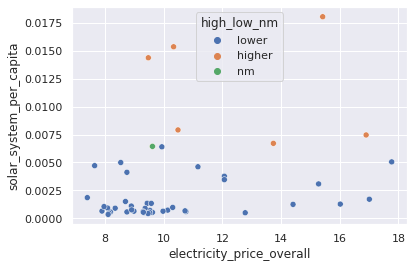

In [150]:
sns.scatterplot(x='electricity_price_overall', y="solar_system_per_capita", hue='high_low_nm', data=state_means_df)

Statistical Analysis

In [151]:
print('Higher vs NM: ', scipy.stats.ttest_ind(higher_sat_solar_df['electricity_price_overall'], nm_solar_df['electricity_price_overall']))
print('Lower vs. NM: ', scipy.stats.ttest_ind(lower_sat_solar_df['electricity_price_overall'], nm_solar_df['electricity_price_overall']))

Higher vs NM:  Ttest_indResult(statistic=33.527014283296644, pvalue=1.7789966051350335e-239)
Lower vs. NM:  Ttest_indResult(statistic=5.4703297847657915, pvalue=4.511682151018857e-08)


Reject the null hypothesis that there is no difference between the population means of Higher Saturation States and New Mexico Overall Electricity Price (p << 0.05)

Reject the null hypothesis that there is no difference between the population means of Lower Saturation States and New Mexico Overall Electricity Price (p << 0.05)

In [152]:
print('Higher vs. NM: ', get_95_ci(higher_sat_solar_df['electricity_price_overall'], nm_solar_df['electricity_price_overall']))
print('Lower vs. NM: ', get_95_ci(lower_sat_solar_df['electricity_price_overall'], nm_solar_df['electricity_price_overall']))

Higher vs. NM:  The difference in means at the 95% confidence interval (two-tail) is between -3.8450899824700375 and -3.771960987740398.
Lower vs. NM:  The difference in means at the 95% confidence interval (two-tail) is between -0.5735058945197645 and -0.5353278459596224.


##### Overall Electricity Price Conclusion:

As can be seen by the distribution visualizations most states have low Overall Electricity Price but there is a split distribution so there are also a fairly high number of states with a higher electricty price.

New Mexico has lower Overall Electricity Price than both states with higher and lower solar system saturation but there is a bigger difference with states that have a higher solar system saturation.  

#### Heating Design Temperature

Heating Design Temperature is an Energy Star Certification factor.

EPA recommends 1% cooling season design temperature and 99% heating season design temperature for the weather location that is geographically closest to the home to be certified.

Distribution Visualizations with Box Plot and Histogram

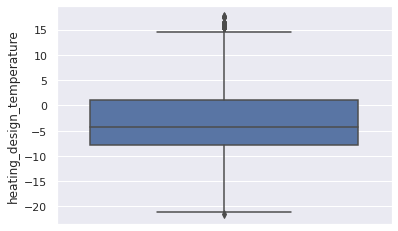

In [153]:
sns.boxplot(y='heating_design_temperature', data=high_corr_solar_df)

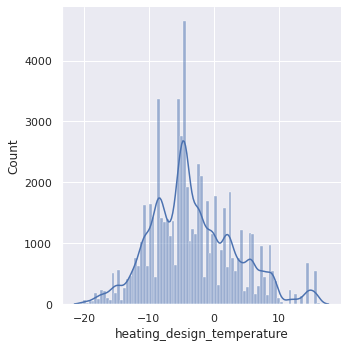

In [154]:
ax = sns.displot(high_corr_solar_df['heating_design_temperature'], kde=True)

Correlation Visualized with Scatter Plot

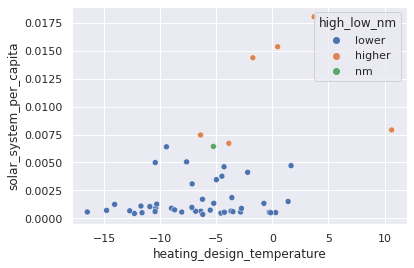

In [155]:
sns.scatterplot(x='heating_design_temperature', y="solar_system_per_capita", hue='high_low_nm', data=state_means_df)

Statistical Analysis

In [156]:
print('Higher vs NM: ', scipy.stats.ttest_ind(higher_sat_solar_df['feedin_tariff'], nm_solar_df['feedin_tariff']))
print('Lower vs. NM: ', scipy.stats.ttest_ind(lower_sat_solar_df['feedin_tariff'], nm_solar_df['feedin_tariff']))

Higher vs NM:  Ttest_indResult(statistic=19.617014839935603, pvalue=7.646147978636352e-85)
Lower vs. NM:  Ttest_indResult(statistic=3.9385070299555234, pvalue=8.209209477179292e-05)


Reject the null hypothesis that there is no difference between the population means of Higher Saturation States and New Mexico Heating Design Temperature (p << 0.05)

Reject the null hypothesis that there is no difference between the population means of Lower Saturation States and New Mexico Heating Design Temperature (p << 0.05)

In [157]:
print('Higher vs. NM: ', get_95_ci(higher_sat_solar_df['feedin_tariff'], nm_solar_df['feedin_tariff']))
print('Lower vs. NM: ', get_95_ci(lower_sat_solar_df['feedin_tariff'], nm_solar_df['feedin_tariff']))

Higher vs. NM:  The difference in means at the 95% confidence interval (two-tail) is between -3.983226335402156 and -3.854620267484174.
Lower vs. NM:  The difference in means at the 95% confidence interval (two-tail) is between -0.33953967727323014 and -0.30854678360470306.


##### Heating Design Temperature Conclusion:

As can be seen by the distribution visualizations the Heating Design Temperature is evenly distributed.

New Mexico has lower Heating Design Temperature than both states with higher and lower solar system saturation but there is a bigger difference with states that have a higher solar system saturation.

### Conclusions and Recommendations

Given the conclusions drawn from analysis it is recommended that New Mexico Solar Companies consider factors that are within the realm of human control. 

The Overall electricity Prices are not controllable by a Solar Company but it is trending upwards according to research done by Paul Gessing. This presents a potential area of opputunity in the coming years for Solar Companies.

See link for more information: https://errorsofenchantment.com/new-report-new-mexico-residential-electricity-rates-rose-9-2-over-past-year/ 

An increase in incentives in any form would also benefit Solar Companies and I would recommend they push for that in the political realm by supporting candidates that are in favor of the Energy Transition Act. In 2019, the legislature and Governor Michelle Lujan Grisham enacted the Energy Transition Act. This legislation commits New Mexico to 50% carbon-free energy by 2030 and 100% carbon free energy by 2045.

See link for more information: https://cvnm.org/a-bold-vision-for-new-mexico/



